## 来源
https://www.cnblogs.com/pinard/p/9614290.html

## SARSA算法流程

**输入**: 迭代轮数$T$, 状态集$S$, 动作集$A$, 步长$\alpha$, 衰减因子$\gamma$, 探索率$\epsilon$.

**输出**: 所有的状态和动作对应的价值$Q$.

1. 随机初始化所有的状态和动作对应的价值$Q$. 对于终止状态其$Q$值初始化为0.

2. 从$i$到$T$进行迭代.

   1. 初始化$S$为当前状态序列的第一个状态. 设置$A$为$\epsilon$贪婪法在当前状态$S$选择的动作.

   2. 在状态$S$执行动作$A$, 得到新的状态$S'$和奖励$R$.

   3. 用$\epsilon$贪婪法在状态$S'$选择新的动作$A'$.

   4. 更新价值函数$Q(S,A)$:
      $$
      Q(S,A)=Q(S,A)+\alpha(R+\gamma Q(S',A')-Q(S,A))
      $$

   5. $S=S', A=A'$

   6. 如果$S'$为终止状态, 当前轮迭代完毕, 否则转到步骤2.

步长$\alpha$一般需要随着迭代的进行逐渐变小, 这样才能保证动作价值函数$Q$可以收敛. 当$Q$收敛时，我们的策略$\epsilon$贪婪法也就收敛了.

下面我们用一个著名的实例Windy GridWorld来研究SARSA算法。
如下图一个10×7的长方形格子世界，标记有一个起始位置 S 和一个终止目标位置 G，格子下方的数字表示对应的列中一定强度的风。当个体进入该列的某个格子时，会按图中箭头所示的方向自动移动数字表示的格数，借此来模拟世界中风的作用。同样格子世界是有边界的，个体任意时刻只能处在世界内部的一个格子中。个体并不清楚这个世界的构造以及有风，也就是说它不知道格子是长方形的，也不知道边界在哪里，也不知道自己在里面移动移步后下一个格子与之前格子的相对位置关系，当然它也不清楚起始位置、终止目标的具体位置。但是个体会记住曾经经过的格子，下次在进入这个格子时，它能准确的辨认出这个格子曾经什么时候来过。格子可以执行的行为是朝上、下、左、右移动一步，每移动一步只要不是进入目标位置都给予一个 -1 的惩罚，直至进入目标位置后获得奖励 0 同时永久停留在该位置。现在要求解的问题是个体应该遵循怎样的策略才能尽快的从起始位置到达目标位置。
![Windy GridWorld](https://images2018.cnblogs.com/blog/1042406/201809/1042406-20180909184205162-391171363.jpg "Windy GridWorld")

In [12]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# world height
WORLD_HEIGHT = 7

# world width
WORLD_WIDTH = 10

# wind strength for each column
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

# possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3

# probability for exploration
EPSILON = 0.1

# Sarsa step size
ALPHA = 0.5

# reward for each step
REWARD = -1.0

START = [3, 0]
GOAL = [3, 7]
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

In [13]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        # 不能超过上边界
        return [max(i - 1 - WIND[j], 0), j]
    elif action == ACTION_DOWN:
        # 不能同时超过上下边界
        return [max(min(i + 1 - WIND[j], WORLD_HEIGHT - 1), 0), j]
    elif action == ACTION_LEFT:
        # 不能超过上边界, 同时不能超过左边界
        return [max(i - WIND[j], 0), max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        # 不能超过上边界, 同时不能超过右边界
        return [max(i - WIND[j], 0), min(j + 1, WORLD_WIDTH - 1)]
    else:
        assert False

In [15]:
# play for an episode
def episode(q_value):
    # track the total time steps in this episode
    time = 0

    # initialize state
    state = START

    # choose an action based on epsilon-greedy algorithm
    # 使用贪婪法初始化一个动作
    # 二项分布, 投掷一次硬币, epsilon的概率为1
    if np.random.binomial(1, EPSILON) == 1:
        action = np.random.choice(ACTIONS)
    else:
        # 第(i, j)单元格四个方向的动作价值最大的中, 随机选择动作(可能会出现多个最大动作价值)
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # keep going until get to the goal state
    while state != GOAL:
        # 执行动作, 得到下一个状态
        next_state = step(state, action)
        # 使用贪婪法选择新的状态
        if np.random.binomial(1, EPSILON) == 1:
            next_action = np.random.choice(ACTIONS)
        else:
            values_ = q_value[next_state[0], next_state[1], :]
            next_action = np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

        # Sarsa update
        # 更新价值函数
        q_value[state[0], state[1], action] += \
            ALPHA * (REWARD + q_value[next_state[0], next_state[1], next_action] -
                     q_value[state[0], state[1], action])
        # 更新当前状态和动作
        state = next_state
        action = next_action
        time += 1
    return time

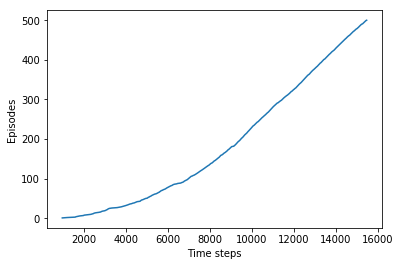

Optimal policy is:
['D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'U', 'R', 'R', 'U', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'U', 'R', 'R', 'R', 'L', 'D']
['D', 'U', 'U', 'R', 'R', 'R', 'U', 'G', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'U', 'D', 'L', 'L']
['U', 'R', 'U', 'R', 'R', 'U', 'U', 'U', 'L', 'U']
['R', 'R', 'R', 'R', 'U', 'U', 'U', 'U', 'U', 'L']
Wind strength for each column:
['0', '0', '0', '1', '1', '1', '2', '2', '1', '0']


In [17]:
def sarsa():
    # 动作价值函数表, 代表每个单元格四个方向上的动作价值
    q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
    episode_limit = 500

    steps = []
    ep = 0
    while ep < episode_limit:
        steps.append(episode(q_value))
        ep += 1
    # 从前往后依次累加
    steps = np.add.accumulate(steps)

    plt.plot(steps, np.arange(1, len(steps) + 1))
    plt.xlabel('Time steps')
    plt.ylabel('Episodes')
    plt.show()
    plt.close()

    # display the optimal policy
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    print('Optimal policy is:')
    for row in optimal_policy:
        print(row)
    print('Wind strength for each column:\n{}'.format([str(w) for w in WIND]))

if __name__ == '__main__':
    sarsa()